In [1]:
import sys
sys.path.append("..")
from diskit.circuit_remapper import *
from diskit.components.layer import *
from qiskit import assemble, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere
import numpy as np
import warnings

warnings.filterwarnings("ignore")

Functions to construct the circuit to do Quantum Fourier Transform

In [2]:
def qft_rotations(circuit, n):
    """Add controlled phase gates as per qft on the first n qubits in circuit"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n) # recursion call
    
def swap_registers(circuit, n):
    """Swap Registers as per QFT scheme"""
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def qft(circuit, n, transpile_swap = False):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

### Create a Distributed Circuit for performing Quantum Fourier Transform

#### For 2 processor with 4 qubits

Define a Topology of 4 qubits with 2 processors each having 2 qubits

In [3]:
circuit_topo = Topology()
circuit_topo.create_qmap(2, [2, 2],"sys_qft")
circuit_topo.qmap, circuit_topo.emap

({'sys_qft0': [Qubit(QuantumRegister(2, 'sys_qft0'), 0),
   Qubit(QuantumRegister(2, 'sys_qft0'), 1)],
  'sys_qft1': [Qubit(QuantumRegister(2, 'sys_qft1'), 0),
   Qubit(QuantumRegister(2, 'sys_qft1'), 1)]},
 {'sys_qft0': Qubit(QuantumRegister(1, 'com_sys_qft0'), 0),
  'sys_qft1': Qubit(QuantumRegister(1, 'com_sys_qft1'), 0)})

In [4]:
remapper = CircuitRemapper(circuit_topo)

Get the registers and total number of qubits

In [5]:
qregs = circuit_topo.get_regs()
n_q = circuit_topo.num_qubits()

Define the monolithic Circuit for performing Fourier Transform of $|0\rangle$

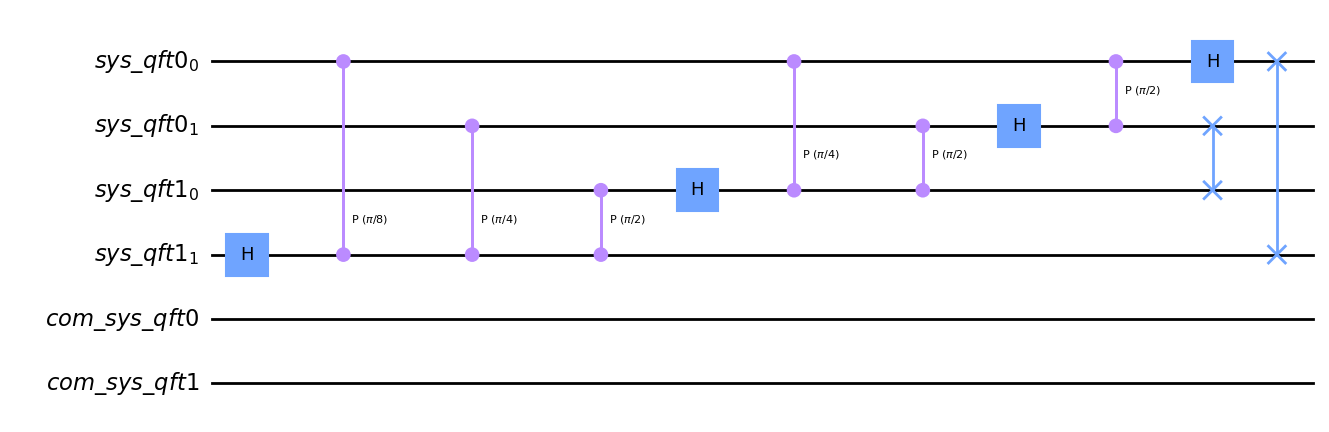

In [6]:
circ_1 = QuantumCircuit(*qregs)
qft_circ = qft(circ_1, n_q)
qft_circ.draw(output='mpl')

We shall need to decompose the swap gates to CNOT before translating to Distributed Circuit.

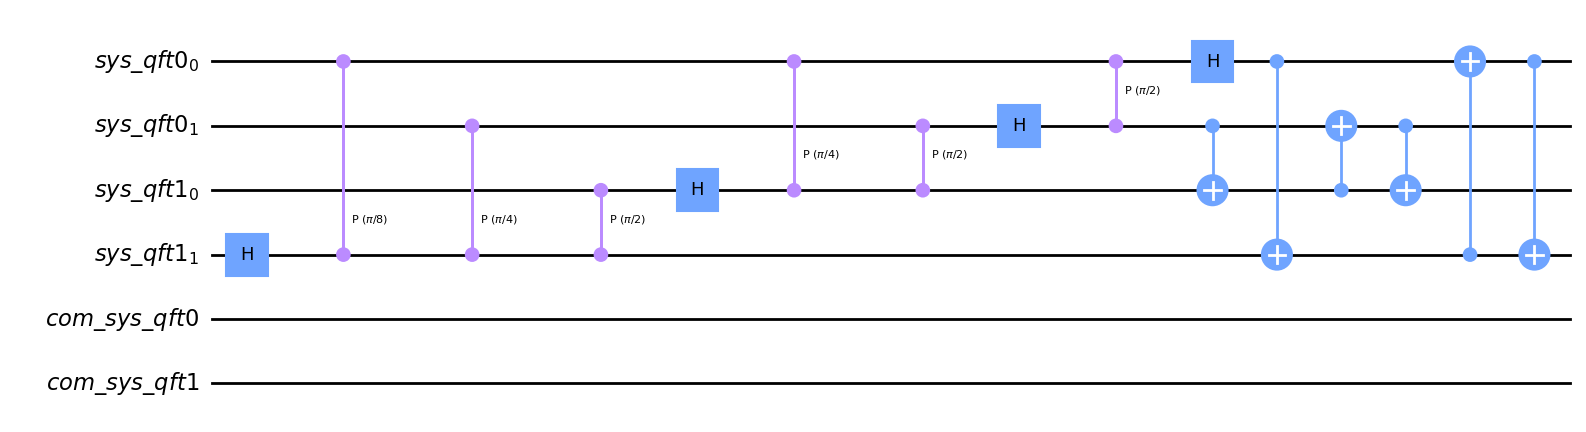

In [7]:
qft_circ.decompose('swap').draw(output='mpl')

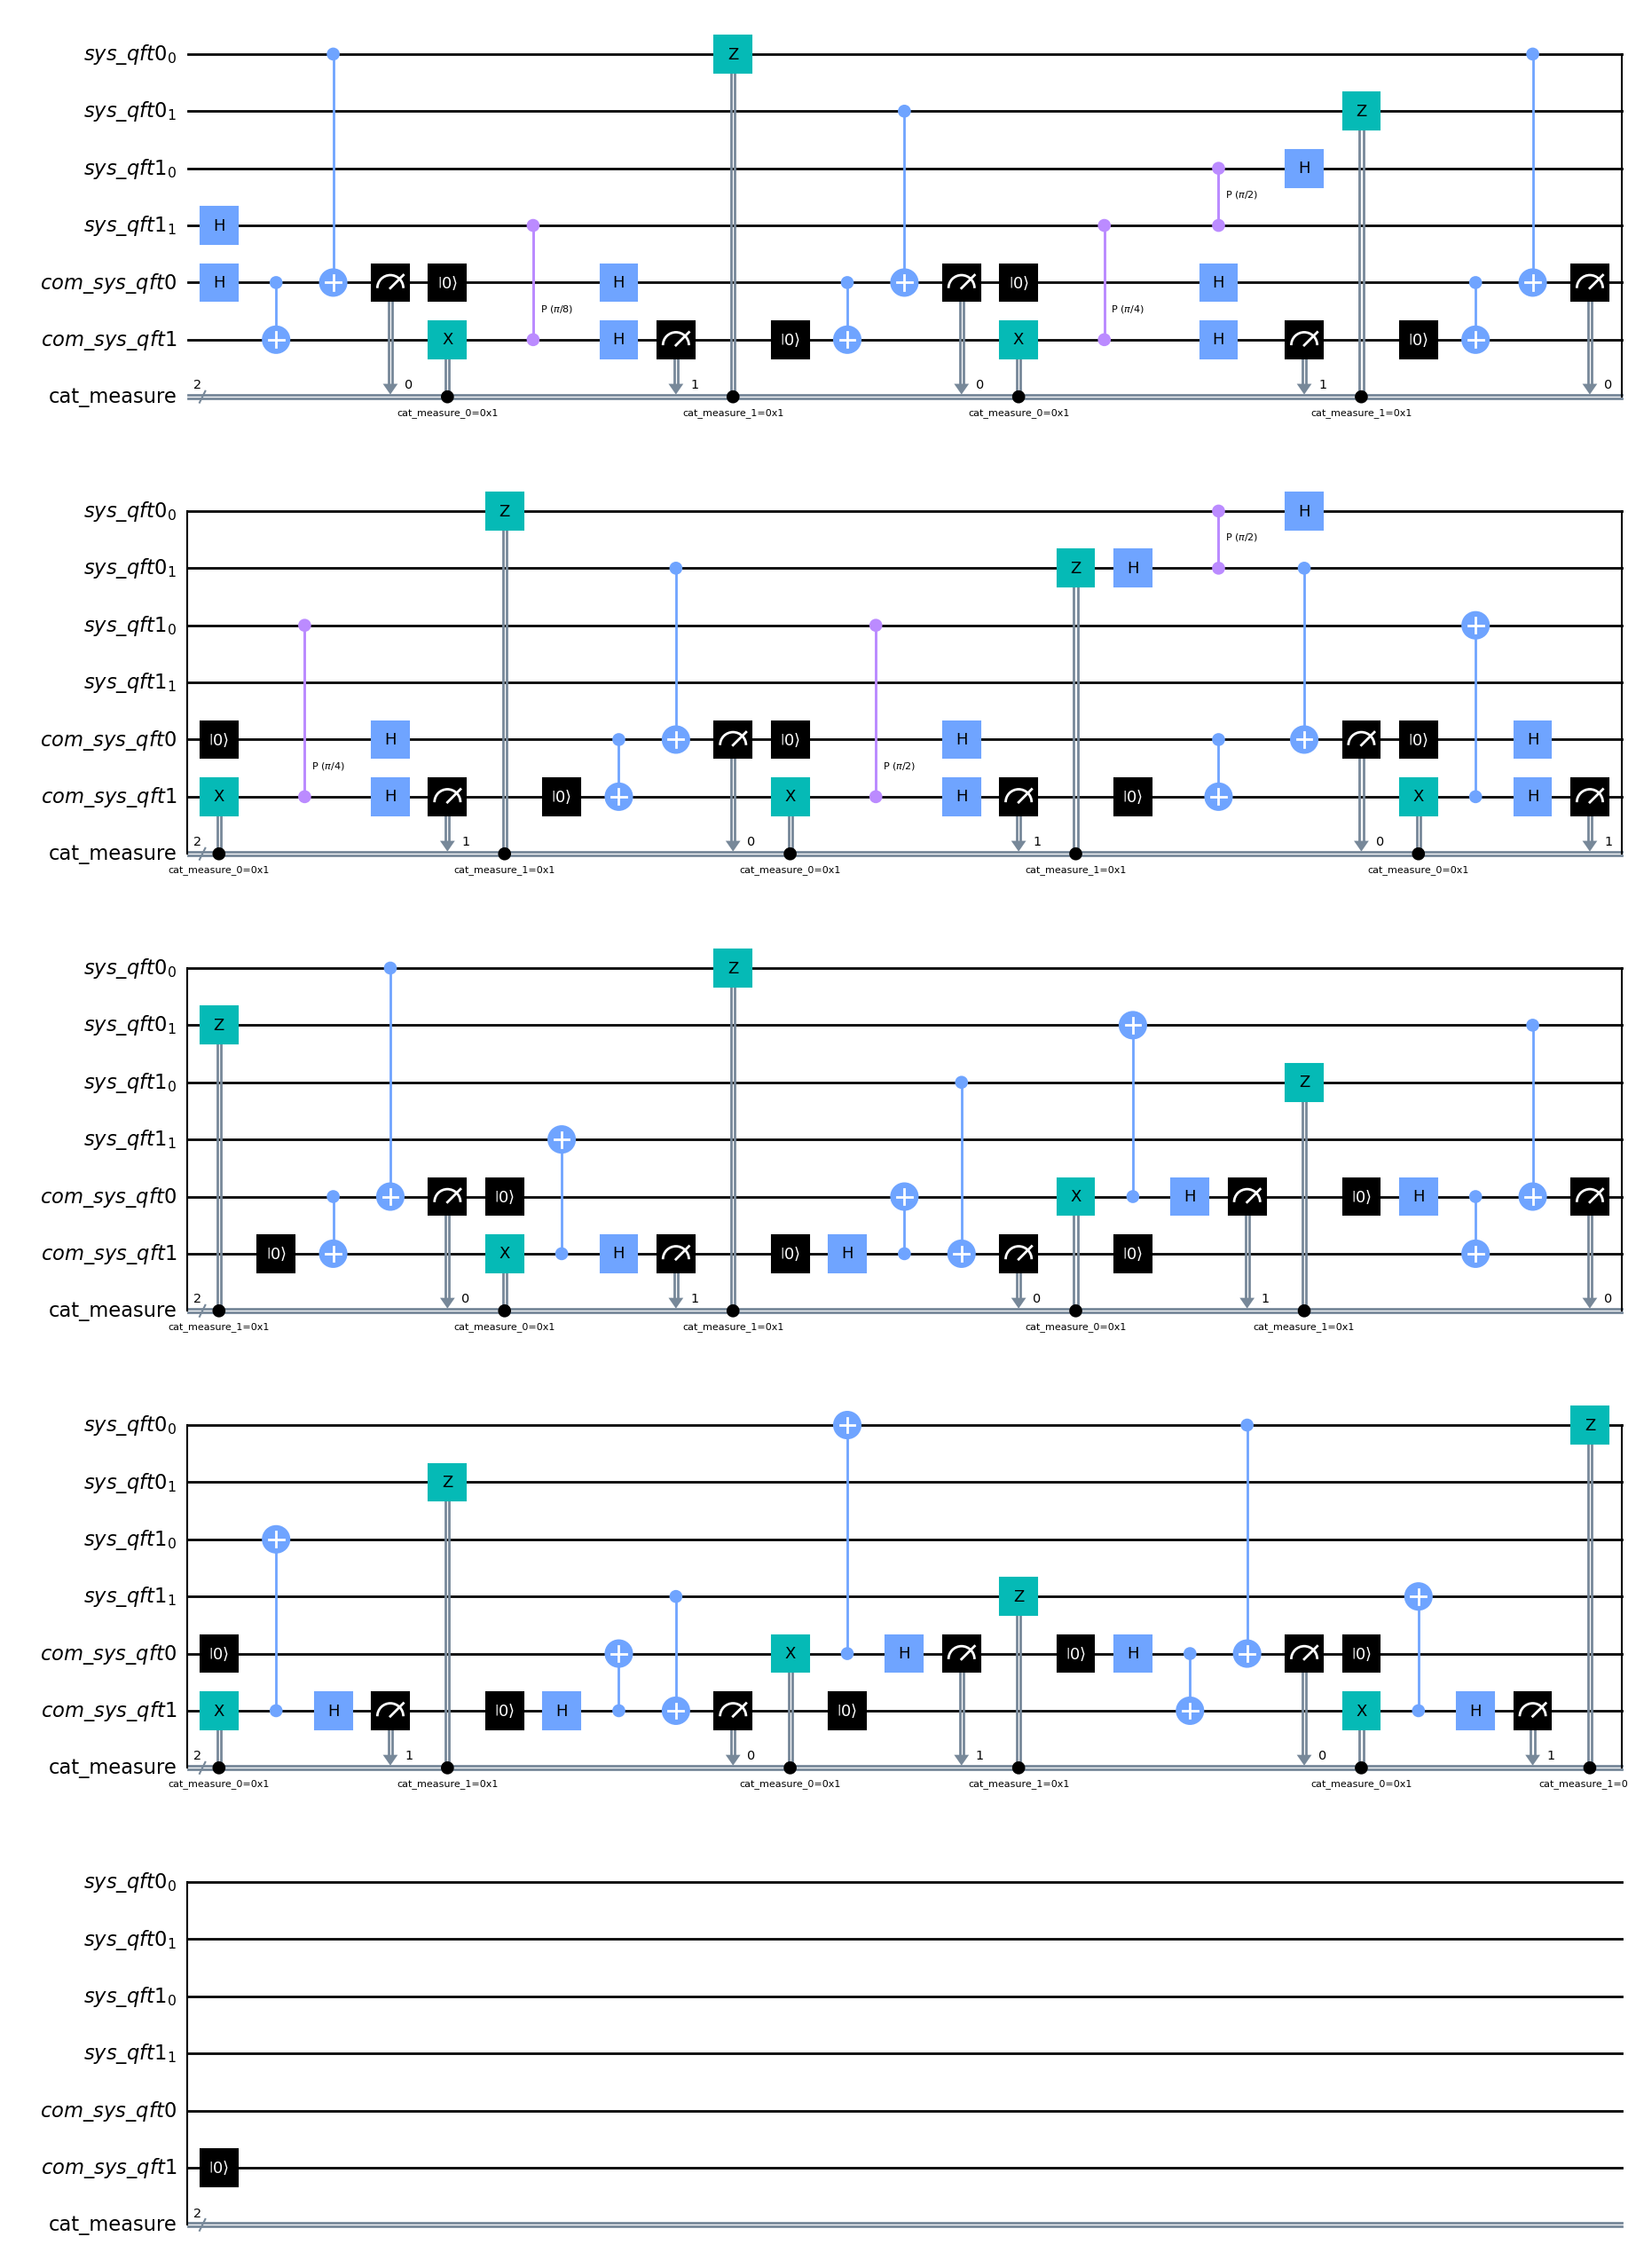

In [8]:
dist_circ_1 = remapper.remap_circuit(qft_circ.decompose('swap'))
dist_circ_1.draw('mpl')

#### For 4 processors with total 16 qubits

Define a Topology of 10 qubits with 4 processors.

In [9]:
circuit_topo = Topology()
circuit_topo.create_qmap(4, [2, 3, 4, 1],"sys_qft")
circuit_topo.qmap, circuit_topo.emap

({'sys_qft0': [Qubit(QuantumRegister(2, 'sys_qft0'), 0),
   Qubit(QuantumRegister(2, 'sys_qft0'), 1)],
  'sys_qft1': [Qubit(QuantumRegister(3, 'sys_qft1'), 0),
   Qubit(QuantumRegister(3, 'sys_qft1'), 1),
   Qubit(QuantumRegister(3, 'sys_qft1'), 2)],
  'sys_qft2': [Qubit(QuantumRegister(4, 'sys_qft2'), 0),
   Qubit(QuantumRegister(4, 'sys_qft2'), 1),
   Qubit(QuantumRegister(4, 'sys_qft2'), 2),
   Qubit(QuantumRegister(4, 'sys_qft2'), 3)],
  'sys_qft3': [Qubit(QuantumRegister(1, 'sys_qft3'), 0)]},
 {'sys_qft0': Qubit(QuantumRegister(1, 'com_sys_qft0'), 0),
  'sys_qft1': Qubit(QuantumRegister(1, 'com_sys_qft1'), 0),
  'sys_qft2': Qubit(QuantumRegister(1, 'com_sys_qft2'), 0),
  'sys_qft3': Qubit(QuantumRegister(1, 'com_sys_qft3'), 0)})

In [10]:
remapper = CircuitRemapper(circuit_topo)

Get the registers and total number of qubits

In [11]:
qregs = circuit_topo.get_regs()
n_q = circuit_topo.num_qubits()

Define the monolithic Circuit for performing Fourier Transform of $|0\rangle$

In [12]:
circ_2 = QuantumCircuit(*qregs)
qft_circ = qft(circ_2, n_q)
# qft_circ.draw(output='mpl')

In [13]:
dist_circ_2 = remapper.remap_circuit(circ_2.decompose('swap'))

Let us check the validity of the working of the distributed version for the 16 Qubit case

First we check the output for monolithic circuit

In [14]:
from qiskit.quantum_info import partial_trace
sim = Aer.get_backend('aer_simulator')

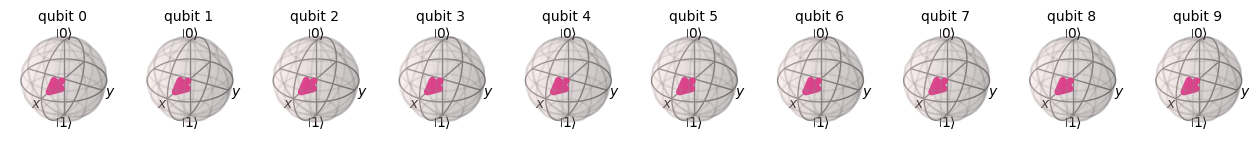

In [15]:
circ2_copy = circ_2.copy()
circ2_copy.save_statevector()
qobj = assemble(circ2_copy)
state = sim.run(qobj).result().get_statevector()

state = partial_trace(state, [10,11,12,13]) ## Trace out the communication qubits (12 - 15)

plot_bloch_multivector(state)

Now We check output of the distributed circuit

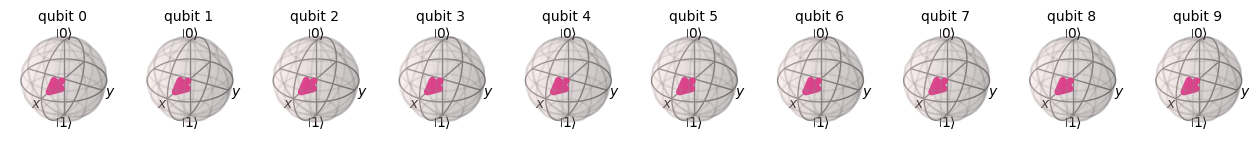

In [16]:
dqc2_copy = dist_circ_2.copy()
dqc2_copy.save_statevector()
qobj = assemble(dqc2_copy)
state = sim.run(qobj).result().get_statevector()

state = partial_trace(state, [10,11,12,13]) ## Trace out the communication qubits (12 - 15)

plot_bloch_multivector(state)

In [17]:
import qiskit.tools.jupyter
%qiskit_version_table